# Getting Started in GRASS with Python, Pixels, and Pigs

***Anna Petrasova, Vaclav Petras and Caitlin Haedrich***

*Center for Geospatial Analytics at NC State University*

In this notebook, we will introduce GRASS and then we will look at an example case study in a small watershed in Eastern North Carolina.

By the end of this notebook, you will have experience with:

*   [Starting a new GRASS project](#start)
*   [Importing data from cloud](#import)
*   [Terrain analysis](#ndvi)
*   [Computing NDVI](#ndvi)
*   [Segmenting imagery to extract waterbodies](#segmentation)
*   Common hydrology tools for [extracting streams](#streams), [computing flow paths](#drain) and [modeling innundation](#hand) using the Heigh Above Nearest Drainage (HAND) method [(Nobre et al., 2011)](https://www.sciencedirect.com/science/article/pii/S0022169411002599).

Let's start with what is [GRASS](https://grass.osgeo.org/)! Check out GRASS [documentation](https://grass.osgeo.org/grass-devel/manuals/index.html) including [GRASS tools](https://grass.osgeo.org/grass-devel/manuals/full_index.html)
and [interfaces](https://grass.osgeo.org/grass-devel/manuals/interfaces_overview.html).

---



<a name="start"></a>
### Start GRASS and Create a New Project

Now, we'll import the Python APIs for GRASS, `grass.script` and `grass.jupyter`. We'll need to ask `grass` to check it's `--config` to see where the python packages are then add them to the system path before we can import them.

In [1]:
import sys
import subprocess

# Ask GRASS where its Python packages are to be able to run it from the notebook
sys.path.append(
    subprocess.check_output(["grass8", "--config", "python_path"], text=True).strip()
)
import grass.script as gs
import grass.jupyter as gj

With our packages imported, we can now create a new [project](https://grass.osgeo.org/grass-dev/manuals/grass_projects.html) called "workshop".

GRASS organizes geospatial work into GRASS projects and mapsets. Each project uses a single coordinate reference system (CRS). Inside a project are mapsets, which act as subprojects where data and analyses are organized. Mapsets can represent different research tasks, study areas, or the work of individual collaborators.

![Projects and mapsets](https://grass.osgeo.org/grass-devel/manuals/project.png)

When we create a new project, we can set the CRS from a georeferenced file (such as a Geotiff) or an EPSG string. Here, we use [EPSG 6542](https://epsg.io/6542), a projection for NC in meters.

In [3]:
gs.create_project("workshop", crs="EPSG:6542")

We start a GRASS session in our new project.

In [2]:
gj.init("workshop");

In this workshop we will be using new GRASS Python API using GRASS preview version.

In [4]:
from grass.tools import Tools

tools = Tools()
tools.g_search_modules(keyword="hydrology")

ToolResult(returncode=0, stdout='
r.accumulate
    keywords: raster,hydrology,accumulation,watershed,subwatershed,stream
              network,longest flow path
    description: Calculates weighted flow accumulation, subwatersheds, stream
                 networks, and longest flow paths using a flow direction map.

r.basins.fill
    keywords: raster,hydrology,watershed
    description: Generates watershed subbasins raster map.

r.carve
    keywords: raster,hydrology
    description: Generates stream channels. Takes vector stream data,
                 transforms it to raster and subtracts depth from the output
                 DEM.

r.drain
    keywords: raster,hydrology,cost surface
    description: Traces a flow through an elevation model or cost surface on a
                 raster map.

r.fill.dir
    keywords: raster,hydrology,sink,fill sinks,depressions
    description: Filters and generates a depressionless elevation map and a
                 flow direction map from a given el



---


<a name="import"></a>
## Import Data

Check the computational region in our new project:

In [ ]:
tools.v_import(input="AOI.geojson", output="AOI")

ToolResult(returncode=0, stdout='[
    {
        "name": "AOI",
        "mapset": "PERMANENT",
        "type": "vector",
        "fullname": "AOI@PERMANENT"
    }
]', stderr='')

In [8]:
aoi_map = gj.InteractiveMap()
aoi_map.add_vector("AOI")
aoi_map.show()
    

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

There are lots of ways to set the computational region (see [g.region](https://grass.osgeo.org/grass-devel/manuals/g.region.html) documentation). Since we don't have any data in our project yet, we'll set it with coordinates.

In [ ]:
tools.g_region(vector="AOI", res=1)
gs.region()

{'projection': 99,
 'zone': 0,
 'n': 131937.0,
 's': 126822.0,
 'w': 702723.0,
 'e': 708447.0,
 'nsres': 3.0,
 'ewres': 3.0,
 'rows': 1705,
 'cols': 1908,
 'cells': 3253140}

We're going to import a digital elevation model (DEM), we will use a GRASS addon [r.in.usgs](https://grass.osgeo.org/grass-devel/manuals/addons/r.in.usgs.html), which uses [TNM Access](https://apps.nationalmap.gov/tnmaccess/) REST API to access USGS data. First install the addon:

In [17]:
tools.g_extension(extension="r.in.usgs")

ToolResult(returncode=0, stdout='Your branch is up to date with 'origin/grass8'.
', stderr='WARNING: Extension <r.in.usgs> already installed. Re-installing...
Fetching <r.in.usgs> from <https://github.com/OSGeo/grass-addons/> (be
patient)...
Already on 'grass8'
Compiling...
Installing...
Updating extensions metadata file...
Updating extension modules metadata file...
Installation of <r.in.usgs> successfully finished
')

Download and reproject a 1/9 arc-second DEM (approx 3-m resolution):

In [5]:
tools.r_in_usgs(product="ned", ned_dataset="ned19sec", flags="i")

ToolResult(returncode=0, stdout='USGS file(s) to download:
-------------------------
Total download size:	209.02 MB
Tile count:	1
USGS SRS:	wgs84
USGS tile titles:
USGS NED ned19_n35x00_w078x00_nc_statewide_2003 1/9 arc-second 2012 15 x 15 minute IMG
-------------------------
', stderr='To download USGS data, remove <i> flag, and rerun r.in.usgs.
')

In [7]:
tools.r_in_usgs(product="ned", ned_dataset="ned19sec", output_name="elevation", verbose=True)

<details>

<summary>Alternative Import Method</summary>

### Download with wget and import with `r.import`

First, download and unzip with bash.

```bash
%%bash
wget https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/19/IMG/ned19_n35x00_w078x00_nc_statewide_2003.zip
unzip ned19_n35x00_w078x00_nc_statewide_2003.zip
```

We'll import our elevation model using [`r.import`](https://grass.osgeo.org/grass-devel/manuals/r.import.html) and create a raster layer called "elevation". The `r.import` tool will reproject the data to the project CRS (thereby avoiding any future CRS mismatches - nice!). We also set it to only import the area within the computational region and to resample it using bilinear interpolation to the resolution of the computational region.

```python
gs.run_command("r.import", input="ned19_n35x00_w078x00_nc_statewide_2003.img", output="elevation", resample="bilinear", extent="region")
```

</details>

Let's display our elevation layer using the `grass.jupyter.Map()` class. The `Map()` class creates and displays GRASS maps as PNG images. `Map()` accepts any [GRASS display tools](https://grass.osgeo.org/grass-devel/manuals/display.html) as a method by replacing the "." with "_" in the module name.
To display the image, we call the show() method. You can also save the image with the save() method.

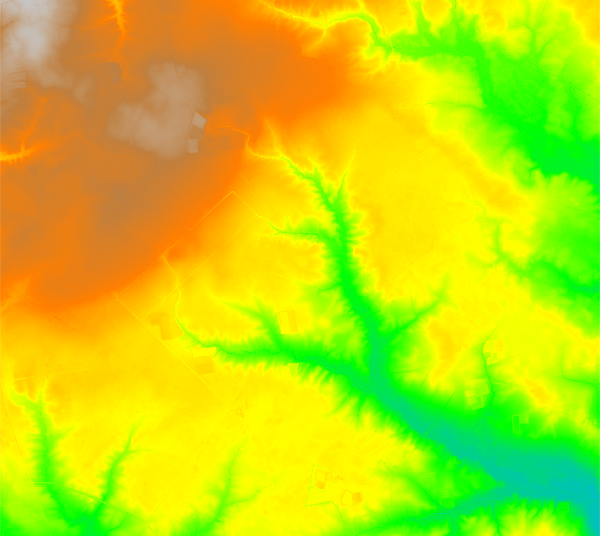

In [8]:
map = gj.Map()
map.d_rast(map="elevation")
map.show()

Now set the computational region to match the elevation layer.

In [11]:
tools.g_region(raster="elevation")



---


## Terrain analysis

Now for our first terrain analysis example. In the next two cells, we use [r.relief](https://grass.osgeo.org/grass-devel/manuals/r.relief.html) and [r.slope.aspect](https://grass.osgeo.org/grass-devel/manuals/r.slope.aspect.html) to compute a shaded relief map and slope map, respectively.

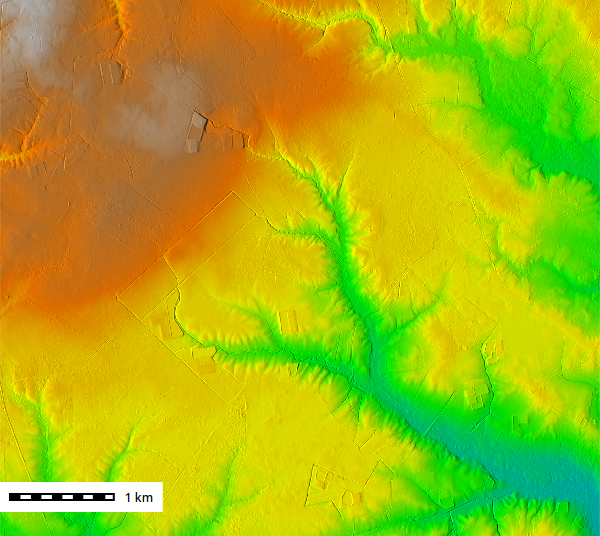

In [9]:
gs.run_command("r.relief", input="elevation", output="relief")

map = gj.Map()
map.d_shade(color="elevation", shade="relief", brighten=50)
map.d_barscale()
map.show()

Let's look at one example of a terrain analysis tool available in GRASS. The [r.geomorphon](https://grass.osgeo.org/grass-devel/manuals/r.geomorphon.html) tool classifies terrain into it's different landforms (i.e. peaks, valleys, ridges,...).

<img src="https://grass.osgeo.org/grass-stable/manuals/legend.png" />

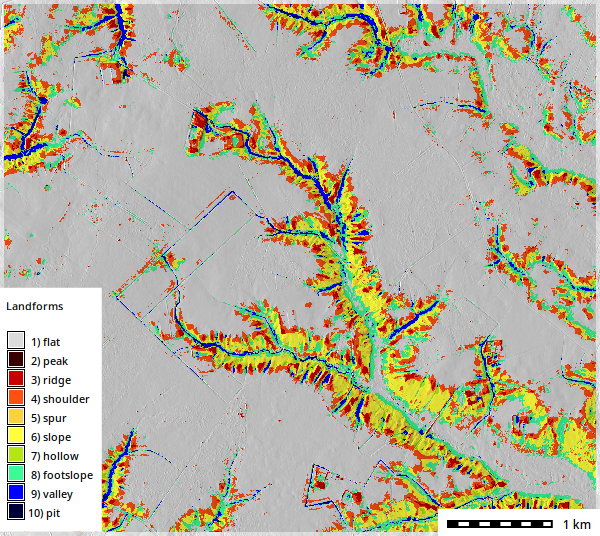

In [ ]:
tools.r_geomorphon(elevation="elevation", forms="landforms", skip=11, search=25)

map = gj.Map()
map.d_shade(color="landforms", shade="relief", brighten=50)
map.d_legend(
    raster="landforms",
    at=(0, 40, 1, 5),
    title="Landforms",
    border_color="none",
    flags="bt"
)
map.d_barscale(at=(73, 5))
map.show()

Let's look into the effect of the parameters of the r.geomorphon tool. We will zoom in on a smaller area in the middle using [Region Manager](https://grass.osgeo.org/grass-devel/manuals/libpython/grass.script.html#grass.script.RegionManager) that restricts the computation to a subregion.

Then we display the landforms at different scales as an animation using [SeriesMap](https://grass.osgeo.org/grass85/manuals/jupyter_intro.html#series-map):

In [ ]:
with gs.RegionManager(grow=-300):
    for i, skip, search in ((1, 7, 15), (2, 15, 25), (3, 25, 50)):
        tools.r_geomorphon(elevation="elevation", forms=f"landforms_{i}", skip=skip, search=search)
    
series_map = gj.SeriesMap()
series_map.add_rasters([f"landforms_{i + 1}" for i in range(3)])
series_map.d_legend(
    raster="landforms",
    at=(0, 40, 1, 5),
    title="Landforms",
    border_color="none",
    flags="bt"
)
series_map.show()


---

## Case Study: Swine lagoons



North Carolina is one of the top pork producing states in the US, surpassed only by Minnesota and Iowa. The large industry in North Carolina consists of hundreds of large-scale farms raise pigs, processing facilities, trucks that transport the animals and fields that grow the grains for feed. Raising over 8 million pigs in a concentrated area creates one big issue: waste.

<img src="https://raw.githubusercontent.com/chaedri/chaedri.github.io/refs/heads/master/images/CAFOs.png" />

The waste is typically stored in large retention ponds referred to as *lagoons*. The waste anaerobically digests and then is spread on the nearby fields as fertilizer. However, during catastorphic flooding events such as [Hurricane Florence in 2018](https://www.npr.org/2018/09/22/650698240/hurricane-s-aftermath-floods-hog-lagoons-in-north-carolina), the flood waters can overtop the sides of the lagoon introducing the waste to the surrounding environment.

<img src="https://modernfarmer.com/wp-content/uploads/2022/02/16442235689_6f9667cc05_k-768x489.jpg" />

Using the near infrared band, we will use an image segmentation tool to isolate the lagoons. Then, we'll use some of the hydrology tools to extract the streams and simulated an innudation flood around the streams to see which lagoons will flood.



### Automated Lagoon Detection

#### Get Imagery
First, let's get some aerial imagery of the study area by importing data through a WMS service.

In [36]:
tools.r_in_wms(url="https://imagery.nationalmap.gov/arcgis/services/USGSNAIPPlus/ImageServer/WMSServer", out="ortho", layer="USGSNAIPPlus")

map = gj.InteractiveMap()
map.add_raster("ortho", opacity=0.7)
map.show()

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [37]:
tools.r_rgb(input="ortho", red="red", green="green", blue="blue")

map = gj.SeriesMap()
map.add_rasters(["red", "green", "blue"])
map.show()

In addition to RGB imagery, we'll get false color imagery that uses the Near Infra-Red (NIR) band.

In [ ]:
tools.r_in_wms(url="https://imagery.nationalmap.gov/arcgis/services/USGSNAIPPlus/ImageServer/WMSServer", out="naip_false", layer="USGSNAIPPlus:FalseColorComposite")

map = gj.InteractiveMap()
map.add_raster("naip_false", opacity=0.7)
map.show()

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

<details>

<summary>Alternative Import Method</summary>

```bash
%%bash
wget https://github.com/ncsu-geoforall-lab/iale-2025-workshop-tl/raw/refs/heads/main/naip_false.pack
r.unpack naip_false.pack
```

</details>

The NAIP false color image is a composite of the NIR, red and green bands. We use the [r.rgb](https://grass.osgeo.org/grass-devel/manuals/r.rgb.html) tool to separate the bands into separate layers.

In [ ]:
tools.r_rgb(input="naip_false", red="nir", green="red", blue="green")

map = gj.SeriesMap()
map.add_rasters(["nir", "red", "green"])
map.show()

<a name="ndvi"></a>

Since we have the NIR band, we can now compute NDVI:

$$
NDVI = \frac{NIR - Red}{NIR + Red}
$$

In [40]:
tools.r_mapcalc(expression="ndvi = ((float(nir) - float(red)) / (float(nir) + float(red)))")

# Use built-in NDVI color pallete
tools.r_colors(map="ndvi", color="ndvi")

map = gj.InteractiveMap()
map.add_raster("ndvi", opacity=0.5)
map.show()

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

<a name="segmentation"></a>
#### Lagoon Extraction with Image Segmentation

Looking at the NIR band, it's clear that the lagoons and water bodies have the lowest values. We will isolate them by segmenting the image using all 4 bands ([i.segment](https://grass.osgeo.org/grass-devel/manuals/i.segment.html)) then using zonal statistics with the NIR band ([r.stats.zonal](https://grass.osgeo.org/grass-devel/manuals/r.stats.zonal.html)) to find the patches with the lowest NIR values. Using a threshold, we separate the lagoons from the other patches.

First, we segment the image.

In [ ]:
gs.run_command("i.segment", group=["nir", "red", "green", "blue"], output="segments", threshold=0.5, minsize=100)

map = gj.Map()
map.d_rast(map="segments")
map.show()

Use [r.stats.zonal](https://grass.osgeo.org/grass-devel/manuals/r.stats.zonal.html) to compute the average NIR value for each patch.

In [ ]:
gs.run_command("r.stats.zonal", base="segments", cover="nir", method="average", output="segments_nir")

map = gj.Map(width=900, height=500)
map.d_rast(map="segments_nir")
map.d_legend(raster="segments_nir", flags="dt", label_step=20)
map.show()

Based on the histogram, separate lagoons using a threshold of 40. Cells below the threshold will equal 1, all others will be null.
We will convert the raster patches into vector areas with
[r.to.vect](https://grass.osgeo.org/grass-devel/manuals/r.to.vect.html).

In [ ]:
gs.mapcalc("lagoons = if(segments_nir < 40, 1, null())")
gs.run_command("r.to.vect", input="lagoons", output="lagoons", type="area")

map = gj.InteractiveMap()
map.add_vector("lagoons", opacity=0.7)
map.show()

Finally, we'll place a vector point in the centroid of each lagoon. To do that,
convert the areas in points by extracting the area centroids with
[v.type](https://grass.osgeo.org/grass-devel/manuals/v.type.html).

In [ ]:
gs.run_command("v.type", input="lagoons", output="lagoon_points", from_type="centroid", to_type="point")

map = gj.Map()
map.d_rast(map="ortho")
map.d_vect(map="lagoon_points", size=15, icon="basic/point")
map.show()

Tada! We have identified all the lagoons in the study area.


### Lagoon Flood Risk

Let's use these lagoon points to answer 4 questions:
1. If the lagoons overflowed, what path would the waste travel to the nearest waterway?
2. If the stream water level rose 1 meter, would any of the lagoon be breached?
3. What is the upstream contributing area for a hypothetical sample point?
4. What are the overland flow dynamics during a heavy rainstorm in the upstream contributing area?

<a name="drain"></a>
__Question 1:__ *If the lagoons overflowed or were breached, what path would the waste travel to the nearest waterway?*

(This does happen and has serious consequences:  [news article](https://www.newsobserver.com/news/state/north-carolina/article264779224.html)).

The [r.watershed](https://grass.osgeo.org/grass-devel/manuals/r.watershed.html) tool is a popular and powerful tool for hydrology. Check out all of the outputs it can compute in the [manual page](https://grass.osgeo.org/grass-devel/manuals/r.watershed.html). Here we'll use it to compute the flow accumulation (how many cells are upstream of a given cell) and drainage direction (what direction a particle would flow from each cell). By default the tool uses multiple flow direction algorithm, which works better on a flat landscape. We don't need to fill sinks, because r.watershed uses least-cost path approach for routing through depressions. Then, we'll use [r.path](https://grass.osgeo.org/grass-devel/manuals/r.path.html) to trace the route of the waste being transported downhill from the lagoon.

In [ ]:
gs.run_command("r.watershed", elevation="elevation", accumulation="accumulation", drainage="drainage")

In [ ]:
map = gj.InteractiveMap()
map.add_raster("accumulation", opacity=0.5)
map.show()

In [ ]:
gs.run_command("r.path", input="drainage", vector_path="drain", start_points="lagoon_points")

Let's see what is the landcover the water from lagoons would flow through:

In [ ]:
map = gj.Map()
map.d_shade(color="ortho", shade="relief", brighten=50)
map.d_vect(map="drain", width=1, color="blue")
map.show()

<a name="hand"></a>
__Question 2:__ *If the stream water level rose 1 meter, would any of the lagoon be breached?*

To answer this question, we'll use the HAND (height above nearest drainage) method to model the flood [(Nobre et al., 2011)](https://www.sciencedirect.com/science/article/pii/S0022169411002599).

First, we'll add the two extensions we need for this workflow.

In [ ]:
gs.run_command("g.extension", extension="r.lake.series")
gs.run_command("g.extension", extension="r.stream.distance")

<a name="streams"></a>
Use the elevation and the flow accumulation raster we computed with `r.watershed` to extract the streams and vectors. The threshold is the minimum flow accumulation for a cell to be part of the stream network.

In [ ]:
gs.run_command("r.stream.extract", elevation="elevation", accumulation="accumulation",
               stream_raster="streams", stream_vector="streams", direction="direction", threshold=100000)
map = gj.Map()
map.d_shade(color="elevation", shade="relief", brighten=50)
map.d_vect(map="streams", width=1, color="blue", layer=1)
map.d_vect(map="lagoons", fill_color="none")
map.show()

The [r.lake](https://grass.osgeo.org/grass-devel/manuals/r.lake.html) tool is a "bathtub" model for flooding.

In [ ]:
gs.run_command("r.lake", elevation="elevation", water_level=25, lake="flood", seed="streams")
map = gj.Map()
map.d_shade(color="flood", shade="relief", brighten=50)
map.d_vect(map="streams", width=1, color="blue", layer=1)
map.d_vect(map="lagoons", fill_color="none")
map.show()

As we can see above, `r.lake` is filling the DEM from the lowest point on the the streams network. But what if we wanted to flood each section of the stream by a meter? For this, we can use a height above nearest drainage (HAND) raster instead of the elevation raster for the "elevation" parameter.
HAND represents the vertical distance between any point on a landscape and the nearest stream or drainage channel.

We can create the HAND raster using [r.stream.distance](https://grass.osgeo.org/grass-devel/manuals/addons/r.stream.distance.html).

In [ ]:
gs.run_command("r.stream.distance", stream_rast="streams", direction="direction", elevation="elevation", method="downstream", difference="HAND")
map = gj.Map()
map.d_shade(color="HAND", shade="relief", brighten=50)
map.d_vect(map="streams", width=1, color="blue", layer=1)
map.d_vect(map="lagoons", fill_color="none")
map.show()

In [ ]:
gs.run_command("r.lake", elevation="HAND", water_level=1, lake="flood", seed="streams")
map = gj.Map()
map.d_shade(color="flood", shade="relief", brighten=50)
map.d_vect(map="streams", width=1, color="blue", layer=1)
map.d_vect(map="lagoons", fill_color="none")
map.show()

To create a timeseries of the innundation, we can use [r.lake.series](https://grass.osgeo.org/grass-devel/manuals/addons/r.lake.series.html).

In [ ]:
gs.run_command("r.lake.series", elevation="HAND", seed_raster="streams", start_water_level=0, end_water_level=1, water_level_step=0.1, output="inundation")


In [ ]:
map = gj.TimeSeriesMap()
map.d_rast(map="relief")
map.d_vect(map="lagoons", fill_color="none")
map.add_raster_series("inundation")
map.show()

It looks like one lagoon would be breached and a few more are very close to flooding.

__Question 3:__ *What is the upstream contributing area for a hypothetical sample point?*

To do this, we will extract a coordinate from a section of stream and then use [r.water.outlet](https://grass.osgeo.org/grass-devel/manuals/r.water.outlet.html) with the drainage direction raster to compute the upstream contribute area.

In [ ]:
gs.run_command("v.extract", input="streams", output="stream_points", type="point", where="x IS NOT NULL")

In [ ]:
map = gj.Map()
map.d_rast(map="relief")
map.d_vect(map="streams", color="blue")
map.d_vect(map="stream_points", display="cat", label_color="white", label_size=10)
map.show()

Let's use point with category 15. Vector attributes are stored in a SQL database inside the project. We use [v.to.db](https://grass.osgeo.org/grass-devel/manuals/v.to.db.html) to add the feature coordinates to the attribute table, then [v.db.select](https://grass.osgeo.org/grass-devel/manuals/v.db.select.html) to select the category and coordinates and show them as a Pandas dataframe.

In [ ]:
import pandas as pd

gs.run_command("v.to.db", map="stream_points", option="coor", type="point", columns="x,y")
df = pd.DataFrame(gs.parse_command("v.db.select", map="stream_points", columns="cat,x,y", format="json")["records"])
df

In [ ]:
[df.loc[8, 'x'], df.loc[8, 'y']]

Finally, use [r.water.outlet](https://grass.osgeo.org/grass-devel/manuals/r.water.outlet.html) to compute the upstream contributing area.

In [ ]:
gs.run_command("r.water.outlet", input="direction", output="basin_15", coordinates=[df.loc[8, 'x'], df.loc[8, 'y']])
map = gj.Map()
map.d_shade(color="basin_15", shade="relief", brighten=50)
map.show()

__Question 4:__ *What are the overland flow dynamics during a heavy rainstorm in basin 15?*

We're going to use [r.sim.water](https://grass.osgeo.org/grass-devel/manuals/r.sim.water.html) to model overland flow. The `r.sim.water` tool is the GRASS implementation of the SIMWE model ([Mitas and Mitasova, 1998](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/97WR03347)), a monte carlo path-tracing approach to solving the St. Venant equations for overland flow.

First, let's set the computational region to the extent of `basin_15` and a lower resolution (6 meters instead of 3) for faster compute times.

In [ ]:
gs.run_command("g.region", zoom="basin_13", res=6)

Apply a mask over the areas outside `basin_15`. Now, only areas inside `basin 15` will be displayed or used in any computation. Unlike computational region, [r.mask](https://grass.osgeo.org/grass-devel/manuals/r.mask.html) can have boundaries that are not rectangular.

In [ ]:
gs.run_command("r.mask", raster="basin_15")

Run `r.sim.water` after computing the x and y direction derivatives. We'll run a 30-minute rainstorm using the default rainfall rate of 50 mm/hr. The output will be a series a map showing water depth at each minute.

In [ ]:
gs.run_command('r.slope.aspect', elevation="elevation", dx="dx", dy="dy")
gs.run_command('r.sim.water', elevation="elevation", dx="dx", dy="dy", depth="depth", flags="t", niterations=30)

Finally, we'll create a temporal dataset and register the output depth maps. GRASS has [a library of tools](https://grass.osgeo.org/grass-devel/manuals/temporalintro.html) for temporal analyses but here, we will just create an animation of the timeseries.

In [ ]:
# Create a time series
gs.run_command("t.create",
               output="depth",
               temporaltype="relative",
               title="Overland flow depth",
               description="Overland flow depth")

# Register the time series
maps = gs.list_strings(type="raster", pattern="depth*")
gs.run_command("t.register", input="depth", maps=maps)

In [ ]:
flow_map = gj.TimeSeriesMap()
flow_map.add_raster_series("depth")
flow_map.show()

Remove the mask and reset the computational region to the original region.

In [ ]:
# Remove mask
gs.run_command("r.mask", flags="r")
# Re-set region
gs.run_command("g.region", n=131934, s=126825, w=702726, e=708443, res=3, flags="a")

---

## Challenge: Develop your own workflow

We'll take the next 20 minutes to each work develop our own workflow based on a DEM. In the final part of the workshop, we'll adapt these workflows for Tangible Landscape.

Here are some activity ideas, sorted by complexity:

**Easier**
* Compute watersheds and then compute average slope value for each watershed. Experiment with watershed size. Use [r.watershed](https://grass.osgeo.org/grass-devel/manuals/r.watershed.html), [r.slope.aspect](https://grass.osgeo.org/grass-devel/manuals/r.slope.aspect.html) and [r.stats.zonal](https://grass.osgeo.org/grass-devel/manuals/r.stats.zonal.html).

* Compute global solar irradiation (daily radiation sum in Wh/m2.day) for today using [r.sun](https://grass.osgeo.org/grass-devel/manuals/r.sun.html), use `glob_rad` parameter.
First compute slope and aspect as inputs to r.sun. Find the day of the year using a Python code snippet found in r.sun documentation.

* Similarly, compute insolation time (the amount of time a location receives sunlight within a day) for today using [r.sun](https://grass.osgeo.org/grass-devel/manuals/r.sun.html).

* Derive upstream contributing area from a point with [r.water.outlet](https://grass.osgeo.org/grass-devel/manuals/r.water.outlet.html).

* Compute topographic wetness index with [r.topoidx](https://grass.osgeo.org/grass-devel/manuals/r.topidx.html).

* Compute terrain depressions with [r.fill.dir](https://grass.osgeo.org/grass-devel/manuals/r.fill.dir.html) and visualize them.


**Medium**
* Find the highest (or lowest point) on the landscape and compute a viewshed from that point. Use [r.univar](https://grass.osgeo.org/grass-devel/manuals/r.univar.html) to get the elevation value, [r.mapcalc](https://grass.osgeo.org/grass-devel/manuals/r.mapcalc.html) to extract the raster cell, [r.stats](https://grass.osgeo.org/grass-devel/manuals/r.stast.html) to get the coordinate and
[r.viewshed](https://grass.osgeo.org/grass-devel/manuals/r.viewshed.html) to compute the viewshed.

* Create a lake where water level is relative to the altitude of the seed cell. Use function [gs.raster.raster_what](https://grass.osgeo.org/grass-devel/manuals/libpython/script.html#script.raster.raster_what) or [r.what](https://grass.osgeo.org/grass-devel/manuals/r.what.html) to obtain the elevation value of the DEM and create a lake ([r.lake](https://grass.osgeo.org/grass-devel/manuals/r.lake.html)) with water level being for example 5 m higher.



**Challenging**
* Compute the least cost path ([r.cost](https://grass.osgeo.org/grass-devel/manuals/r.cost.html) followed by [r.drain](https://grass.osgeo.org/grass-devel/manuals/r.drain.html)) between two points (e.g., two lagoon points) where the cost is the slope (i.e. the flatest path between two points).

* Derive peaks using either [r.geomorphon](https://grass.osgeo.org/grass-devel/manuals/r.geomorphon.html) or [r.param.scale](https://grass.osgeo.org/grass-devel/manuals/r.param.scale.html) and convert them to points (using [r.to.vect](https://grass.osgeo.org/grass-devel/manuals/r.to.vect.html) and [v.type](https://grass.osgeo.org/grass-devel/manuals/v.type.html). From each of those points compute visibility with observer height of your choice a derive a cumulative viewshed layer where the value of each cell represents the number of peaks the cell is visible from (use [r.series](https://grass.osgeo.org/grass-devel/manuals/r.series.html)).





---



## From Notebook Workflow to Executable Script

Tangible Landscape uses scripts to execute analyses on the scanned terrain. Here we show some examples of how to structure GRASS Python scripts.

The `%%writefile` cell magic takes the content of the cell and writes it to a file. The `%%python` magic will execute the file.
Name your file in some unique name, e.g. `yourlastname.py`

In [ ]:
%%writefile yourlastname.py
import grass.script as gs

# modify here
# change function name
def myanalysis(elevation):
    """Computes profile curvature"""
    gs.run_command("r.slope.aspect", elevation=elevation, pcurvature="pcurvature")

if __name__ == "__main__":
    elevation = "elevation"
    myanalysis(elevation=elevation)

Now execute the script:

In [ ]:
%%python yourlastname.py

And visualize the result using the `grass.jupyter` API:

In [ ]:
map = gj.Map()
map.d_rast(map="pcurvature")
map.show()

Now if your workflow requires a vector points map or coordinates, use this template:

In [ ]:
%%writefile yourlastname.py
import grass.script as gs

def get_coordinates(points):
    """Helper function to get coordinate pairs from a vector point layer.
    Do not modify."""
    data = gs.read_command("v.out.ascii", input=points, separator="comma").splitlines()
    return [[float(coor) for coor in point.split(",")[:2]] for point in data]

# modify here
# change function name
def myanalysis(elevation, points):
    """Traces a flow through an elevation model"""
    coordinates = get_coordinates(points)
    if coordinates:
        gs.run_command("r.drain", input=elevation, output="drain", drain="drain_vector", start_coordinates=coordinates)

if __name__ == "__main__":
    elevation = "elevation"
    points = "lagoon_points"
    myanalysis(elevation=elevation, points=points)

In [ ]:
%%python yourlastname.py

In [ ]:
map = gj.Map()
map.d_rast(map="elevation")
map.d_vect(map="drain_vector")
map.show()

Now download the script to your computer.